# Hluboké zpětnovazební učení

Dneska se podíváme na hluboké zpětnovazební učení, které kombinuje dva námi už známé přístupy -- zpětnovazební učení a hluboké neuronové sítě. Tato technika umožňuje vytváření mocných agentů, kteří jsou schopni se trénovat pouze z her 'sám se sebou', jako jsou šachy, go apod. Díky tomu se dokázaly naučit hrát na úrovni lidských hráčů, ba je i překonávat.

## Hluboké Q-učení

Dnes se podíváme na agenta pro hluboké Q-učení, který je podobný klasickému Q-učení, akorát místo matice Q, která pro každý stav a akci počítala odměnu, budeme mít neuronovou síť. Implementace je tedy celkem přímočará -- musíme agentovi definovat model neuronové sítě, který bude předpovídat hodnoty funkce Q. Na vstupu tedy bude dostávat stav a bude nám vracet ohodnocení všech akcí. Příklad je inspirován příkladem [odsud](https://keon.io/deep-q-learning/).

In [1]:
import random
from collections import deque
import tensorflow as tf
import numpy as np
import gym
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.nn import relu
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\katie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Protože ale update vah po každém kroku by byl hrozně pomalý a navíc bychom ho dělali jen pro ten jeden poslední krok, uděláme to chytřeji. Do bufferu si budeme ukládat minulý stav, akci, nový stav a odměnu a po každém kroku si z bufferu vybereme náhodnou trénovací množinu několika minibatchů, na jejichž základě upravíme váhy sítě tak, že síť spočítá odměnu pro danou akci a chybu spočítáme pouze druhou mocninou rozdílu odměny od prostředí a odměny od sítě a ta se pak backpropaguje zpátky. Toto za nás udělá metoda fit, jen jí musíme předat stavy a požadované výstupy.

In [2]:
class DeepQLearningAgent:
    def __init__(self, num_inputs, num_outputs, batch_size = 8, num_batches = 16):
        self.num_inputs = num_inputs # state size
        self.num_outputs = num_outputs # action size
        
        self.batch_size = batch_size
        self.num_batches = num_batches
        
        self.epsilon = 1.0 
        self.epsilon_decay = 0.995      
        self.gamma = 0.95
        
        self.memory = deque(maxlen=2000)
        self.build_model()
        self.epsilon_min = 0.01
                 
    # vytvorime model Q-site se dvema skrytymi vrstvami
    def build_model(self):
        self.model = Sequential([])
        self.model.add(Dense(24, activation=relu, input_dim=self.num_inputs, name='dense_11'))
        self.model.add(Dense(24, activation=relu))
        self.model.add(Dense(self.num_outputs, activation='linear'))
        
        opt = tf.keras.optimizers.Adam(lr=0.001)
        self.model.compile(optimizer=opt, loss='mse')
    
    # ulozeni stavu, akce, odmeny a noveho stavu do bufferu (done ukazatel, zda je to cilovy stav)
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    # vraci akci - pokud trenujeme tak epsilon-greedy, jinak nejlepsi podle site
    def action(self, state, train=False):
        if train and np.random.uniform() < self.epsilon:
            return np.random.randint(self.num_outputs)
        else: 
            return np.argmax(self.model.predict(state)[0])

    # trenovani s pomoci bufferu
    def train(self):
        for _ in range(self.num_batches):
            # samplovani minibatche z pameti
            batch = random.sample(self.memory, self.batch_size)
            states = np.array([s for (s, _, _, _, _) in batch])
            next_states = np.array([ns for (_, _, _, ns, _) in batch])
            states = states.reshape((-1, self.num_inputs))
            next_states = next_states.reshape((-1, self.num_inputs))
            
            # predikce odmen za akce
            predicted = self.model.predict(states)
            next_predicted = self.model.predict(next_states)
                           
            # spocitame cilove hodnoty
            for i, (state, action, reward, next_state, done) in enumerate(batch):
                predicted[i][action] = reward
                if not done:
                    predicted[i][action] = reward + self.gamma*np.amax(next_predicted[i])

            self.model.fit(states, predicted, epochs=1, verbose=0)
                           
        # snizime epsilon pro epsilon-greedy strategii
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon*self.epsilon_decay

Tentorkrát si vyzkoušíme prostředí [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/), kde máme tyčku ne vozíku, který se pohybuje doprava nebo doleva. Cílem je, aby tyčka nespadla. Odměna +1 je získána za každý časový krok, kdy tyč zůstane vzpřímená. Epizoda končí, když je tyč více než 15 stupňů od svislé osy, nebo když se vozík posune více než 2,4 jednotky od středu.

In [5]:
# vytvorime agenta se 4 vstupy a 2 akcemi
agent = DeepQLearningAgent(4, 2)

# vytvorime prostredi
env = gym.make("CartPole-v1")

# Zde si jen pro zajimavost vypiseme prostor pozorovani a akci
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# spustime trenovani na 1000 epizodach
rewards = []
for i in range(1000):
    obs = env.reset()
    obs = np.reshape(obs, newshape=(1, -1))
    done = False
    R = 0
    t = 0
    while not done:
        old_state = obs
        action = agent.action(obs, train=True)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        r = r if not done else 10 # bonus za uplne vyreseni
        obs = np.reshape(obs, newshape=(1, -1))
        agent.memorize(old_state, action, r, obs, done)
    agent.train()
    
    rewards.append(R)
    print(i, R)


observation space: Box(4,)
action space: Discrete(2)
0 21.0
1 24.0
2 17.0
3 34.0
4 18.0
5 14.0
6 25.0
7 79.0
8 23.0
9 13.0
10 15.0
11 71.0
12 41.0
13 11.0
14 39.0
15 18.0
16 13.0
17 31.0
18 10.0
19 15.0
20 12.0
21 20.0
22 20.0
23 27.0
24 15.0
25 41.0
26 23.0
27 11.0
28 13.0
29 21.0
30 12.0
31 18.0
32 16.0
33 65.0
34 13.0
35 32.0
36 26.0
37 20.0
38 15.0
39 14.0
40 13.0
41 17.0
42 46.0
43 12.0
44 12.0
45 17.0
46 15.0
47 12.0
48 13.0
49 12.0
50 14.0
51 15.0
52 23.0
53 10.0
54 13.0
55 13.0
56 17.0
57 11.0
58 16.0
59 15.0
60 13.0
61 12.0
62 12.0
63 27.0
64 15.0
65 16.0
66 14.0
67 18.0
68 19.0
69 38.0
70 12.0
71 36.0
72 14.0
73 17.0
74 14.0
75 16.0
76 11.0
77 29.0
78 12.0
79 24.0
80 11.0
81 19.0
82 13.0
83 18.0
84 33.0
85 12.0
86 12.0
87 19.0
88 10.0
89 15.0
90 16.0
91 36.0
92 30.0
93 43.0
94 36.0
95 25.0
96 15.0
97 70.0
98 13.0
99 35.0
100 40.0
101 81.0
102 17.0
103 29.0
104 34.0
105 33.0
106 18.0
107 16.0
108 11.0
109 16.0
110 11.0
111 36.0
112 24.0
113 17.0
114 41.0
115 20.0
116 15.0
117 

854 500.0
855 496.0
856 500.0
857 500.0
858 500.0
859 500.0
860 500.0
861 500.0
862 500.0
863 500.0
864 500.0
865 500.0
866 500.0
867 500.0
868 500.0
869 392.0
870 500.0
871 500.0
872 459.0
873 500.0
874 500.0
875 500.0
876 500.0
877 500.0
878 500.0
879 500.0
880 500.0
881 441.0
882 500.0
883 362.0
884 388.0
885 500.0
886 419.0
887 328.0
888 500.0
889 371.0
890 428.0
891 500.0
892 471.0
893 439.0
894 408.0
895 422.0
896 414.0
897 234.0
898 500.0
899 346.0
900 432.0
901 355.0
902 433.0
903 256.0
904 500.0
905 338.0
906 351.0
907 500.0
908 347.0
909 398.0
910 307.0
911 452.0
912 418.0
913 470.0
914 381.0
915 346.0
916 500.0
917 11.0
918 300.0
919 500.0
920 500.0
921 500.0
922 500.0
923 500.0
924 500.0
925 500.0
926 500.0
927 500.0
928 500.0
929 500.0
930 500.0
931 500.0
932 500.0
933 500.0
934 500.0
935 500.0
936 500.0
937 500.0
938 500.0
939 500.0
940 500.0
941 500.0
942 500.0
943 500.0
944 500.0
945 500.0
946 500.0
947 500.0
948 500.0
949 500.0
950 500.0
951 500.0
952 500.0
953 500.0
9

Vyzkoušíme, jak dobře náš agent umí problém řešit a zároveň si i vykreslíme animaci.

In [6]:
env = gym.make("CartPole-v1")
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
obs = np.reshape(obs, newshape=(1, -1))
done = False
R = 0
t = 0
while not done:
    env.render()
    old_state = obs
    action = agent.action(obs, train=False)
    obs, r, done, _ = env.step(action)
    obs = np.reshape(obs, newshape=(1, -1))
    R += r
    t += 1       
print(R)
env.close()

observation space: Box(4,)
action space: Discrete(2)
500.0


Vykreslíme si výsledný graf odměn. Vidíme, že se celkově výsledky zlepšují, ale občas nám spadnou dolu. To se klidně může stát, protože vykreslujeme skóre z jedné hry a občas nějaká holt nevyjde.

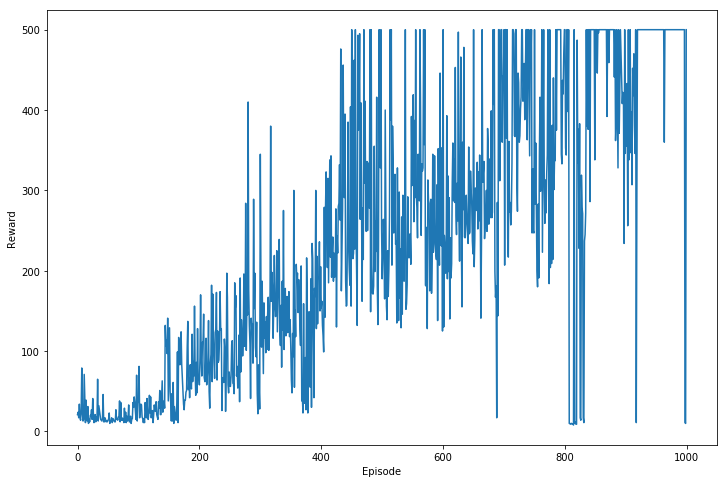

In [7]:
plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

## Úkol na cvičení

Vyberte si z [OpenAI gym](https://gym.openai.com/envs/) některý z problémů se spojitými akcemi a zkuste ho vyřešit pomocí hlubokého Q-učení. Doporučuji si vybrat nějaké s diskrétními akcemi, nebo klidně i spojité, které bude potřeba diskretizovat, ale těch akcí tam bude málo, aby ta síť nemusela mít moc výstupů a netrénovala se příliš dlouho. 